In [2]:
## Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import re
import numpy as np

In [3]:
df_climbs = pd.read_csv('data/climbs.csv')
df_holes = pd.read_csv('data/holes.csv')
df_colors = pd.read_csv('data/placement_roles.csv')


In [27]:
def extract_hold_data(frame_str):
    # Extracting the colors using regex and returning them as a list of strings
    color_strings = re.findall(r'\d+', frame_str)
    return [int(color_str) for color_str in color_strings]


def get_coordinates(id_list, df_holes):
    coordinates = []
    for id_val in id_list:
        coords = df_holes[df_holes['id'] == id_val][['x', 'y']].values.tolist()
        coordinates.extend(coords)
    return coordinates

def color_mapping(index):
    color = df_colors.loc[df_colors.id == index].screen_color.values
    if color: return f"#{color[0]}"
    else: return f"error index"

In [28]:
df_climbs['ids'] = df_climbs['frames'].apply(lambda x: extract_hold_data(x)[0::2])
df_climbs['colors'] = df_climbs['frames'].apply(lambda x: extract_hold_data(x)[1::2])

In [29]:
df_climbs['coordinates'] = df_climbs['ids'].apply(lambda x: get_coordinates(x, df_holes))
# merged_df = pd.merge(df_climbs_exploded, df_holes, left_on='ids', right_on='id', how='inner')


In [6]:
# a = np.asarray(list(df_climbs.query('name == "Fuente"').coordinates)).squeeze()
# a[:, 1]

In [36]:
def plot_climb_by_id(id=1):
    
    hold_pos = np.asarray(df_climbs['coordinates'][id])
    color_ids = df_climbs['colors'][id] 
    colors = [color_mapping(color_id) for color_id in color_ids]
    x_limits = [0, 144]
    y_limits = [0, 156]
    plt.gca().add_patch(Rectangle((x_limits[0], y_limits[0]), x_limits[1]-x_limits[0], y_limits[1]-y_limits[0], facecolor='grey', zorder=0))
    img1 = mpimg.imread('data/kilter_large_holds.png')  
    plt.imshow(img1, extent=[x_limits[0], x_limits[1], y_limits[0], y_limits[1]], zorder=1)  
    img2 = mpimg.imread('data/kilter_small_holds.png')  # Replace with your actual file path
    plt.imshow(img2, extent=[x_limits[0], x_limits[1], y_limits[0], y_limits[1]], aspect='auto', alpha=1, zorder=2)  
    
    x = hold_pos[:, 0]
    y = hold_pos[:, 1]  
    plt.scatter(x, y, facecolors='none', edgecolors=colors, s=100, linewidth=1.5, zorder=3)
    plt.axis('off')
    plt.xlim(x_limits)
    plt.ylim(y_limits)
    plt.gca().set_title(df_climbs['name'][id])
    plt.show()

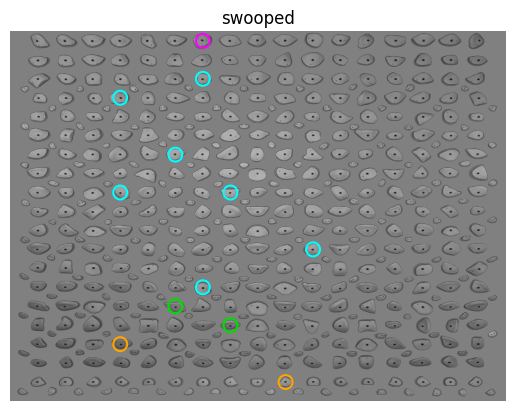

In [37]:
plot_climb_by_id()